In [5]:
!pip install torch --index-url https://download.pytorch.org/whl/cpu

Looking in indexes: https://download.pytorch.org/whl/cpu
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached networkx-3.6.1-py3-none-any.whl.metadata (6.8 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.9/188.9 MB 3.0 MB/s eta 0:00:0000:0100:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.4/201.4 kB 2.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 2.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 2.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 kB 2.9 MB/s eta 0:00:00a 0:00:01


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [7]:
df = pd.read_csv("../data/processed/cleaned_reviews.csv")

df = df.dropna(subset=['cleaned_review'])
df['label'] = df['label'].map({'CG': 0, 'OR': 1})

In [8]:
from collections import Counter
from torch.nn.utils.rnn import pad_sequence

def tokenize(text):
    return text.split()

# Build vocabulary
counter = Counter()
for text in df['cleaned_review']:
    counter.update(tokenize(text))

vocab = {word: i+2 for i, (word, _) in enumerate(counter.most_common(10000))}
vocab["<PAD>"] = 0
vocab["<UNK>"] = 1

In [9]:
def encode(text):
    return [vocab.get(word, 1) for word in tokenize(text)]

df['encoded'] = df['cleaned_review'].apply(encode)


In [10]:
class ReviewDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return torch.tensor(self.texts[idx]), torch.tensor(self.labels[idx])

In [11]:
def collate_fn(batch):
    texts, labels = zip(*batch)
    texts = pad_sequence(texts, batch_first=True)
    labels = torch.tensor(labels)
    return texts, labels

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    df['encoded'], df['label'], test_size=0.2, random_state=42
)

train_data = ReviewDataset(X_train.tolist(), y_train.tolist())
test_data = ReviewDataset(X_test.tolist(), y_test.tolist())

train_loader = DataLoader(train_data, batch_size=64, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_data, batch_size=64, collate_fn=collate_fn)

In [13]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        _, (hidden, _) = self.lstm(x)
        out = self.fc(hidden[-1])
        return self.sigmoid(out)

In [14]:
model = LSTMModel(len(vocab), 128, 128)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(5):
    model.train()
    total_loss = 0
    
    for texts, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(texts).squeeze()
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")


Epoch 1, Loss: 317.3575
Epoch 2, Loss: 176.8942
Epoch 3, Loss: 125.7246
Epoch 4, Loss: 92.8490
Epoch 5, Loss: 74.3914


In [15]:
model.eval()
preds = []
true = []

with torch.no_grad():
    for texts, labels in test_loader:
        outputs = model(texts).squeeze()
        preds.extend((outputs > 0.5).int().tolist())
        true.extend(labels.tolist())

print(classification_report(true, preds))

              precision    recall  f1-score   support

           0       0.92      0.88      0.90      4018
           1       0.89      0.92      0.90      4069

    accuracy                           0.90      8087
   macro avg       0.90      0.90      0.90      8087
weighted avg       0.90      0.90      0.90      8087



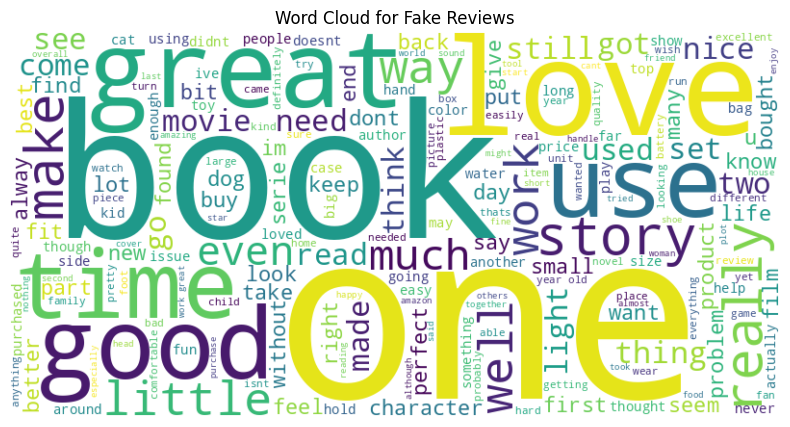

In [21]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv("../data/processed/cleaned_reviews.csv")

fake_reviews = df[df['label'] == 'OR']['cleaned_review']

text = " ".join(fake_reviews)

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white'
).generate(text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for Fake Reviews")
plt.show()